# RUL Regression Modeling

This notebook aims to show the modeling step for predicting the RUL

In [1]:
import os
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression

# ignore warnings
warnings.filterwarnings('ignore')

# definition of constants
DATASOURCE = '../../data/3_model_data'
MODELS = '../../models'
DATANAME = 'train_regression.csv'

In [2]:
# load data
data = pd.read_csv(os.path.join(DATASOURCE, DATANAME))
data.head()

,runtime,tag2,tag3,tag4,tag7,tag9,tag11,tag12,tag14,tag15,tag17,tag20,tag21,rul
0,1,641.82,1589.70,1400.60,554.36,9046.19,47.47,521.66,8138.62,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,9044.07,47.49,522.28,8131.49,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,9052.94,47.27,522.42,8133.23,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,9049.48,47.13,522.86,8133.83,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,9055.15,47.28,522.19,8133.80,8.4294,393,38.90,23.4044,187


In [3]:
data.shape

(20631, 14)

In [4]:
# split into predictors and predicted
x = data.drop(['rul'], axis=1)
y = data[['rul']]

In [5]:
# configure cross validation object
kfold = KFold(n_splits=3, shuffle=True, random_state=2)

## Linear Model Approach

In [6]:
# configure model pipeline and parameters search space
linear_model_pipeline = Pipeline([
    ('feature_selector_1', SelectKBest(f_regression)),
    ('scaler', RobustScaler()),
    ('feature_selector_2', SelectFromModel(Lasso(random_state=2))),
    ('linear_model', Ridge(random_state=2))
])

model_params = {
    'feature_selector_1__k': range(1, 8),
    'feature_selector_2__estimator__alpha': np.random.uniform(0.001, 20, 1000),
    'linear_model__alpha': np.random.uniform(0.001, 20, 1000)
}

In [7]:
# create object to search hyperparameters
linear_search = RandomizedSearchCV(
    estimator=linear_model_pipeline,
    param_distributions=model_params,
    n_iter=50,
    scoring='r2',
    refit=True,
    cv=kfold
)

# ajuste do modelo
linear_search.fit(x, y)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('feature_selector_1',
                                              SelectKBest(score_func=<function f_regression at 0x0000024E5063F310>)),
                                             ('scaler', RobustScaler()),
                                             ('feature_selector_2',
                                              SelectFromModel(estimator=Lasso(random_state=2))),
                                             ('linear_model',
                                              Ridge(random_state=2))]),
                   n_iter=50,
                   param_distributio...
       1.73827702e+01, 8.53746695e+00, 1.99930995e+01, 1.15097886e+01,
       1.94495182e+01, 1.03501207e+01, 6.71988392e+00, 1.45711127e+01,
       1.44413720e+01, 1.20019647e+01, 1.46598536e+00, 1.80359023e+01,
       1.03782666e+01, 6.10575600e+00, 9.41826952e+00, 1.63766312e+01,
       1.09167978e+00, 2.87929259e+00, 2.01283456e+00, 1.03964525e+01,
       1.36387512e-01, 1.10491232e+01, 9.84175165e+00, 1.01769095e+01])},
                   scoring='r2')

In [8]:
print('Best Combination of Parameters:')
print(linear_search.best_params_)

Best Combination of Parameters:
{'linear_model__alpha': 8.572466134339772, 'feature_selector_2__estimator__alpha': 8.667935815636682, 'feature_selector_1__k': 7}


In [9]:
print('Best Average Score:')
print(linear_search.best_score_)

Best Average Score:
0.6474777203564965


In [10]:
# lets analyse the metrics in the full dataset
linear_model = linear_search.best_estimator_

# make predictions
yhat_linear = linear_model.predict(x)

print('Mean Absolute Error: ', mean_absolute_error(y, yhat_linear))
print('R2 Score: ', r2_score(y, yhat_linear))

Mean Absolute Error:  31.347503355287717
R2 Score:  0.6478138962958944


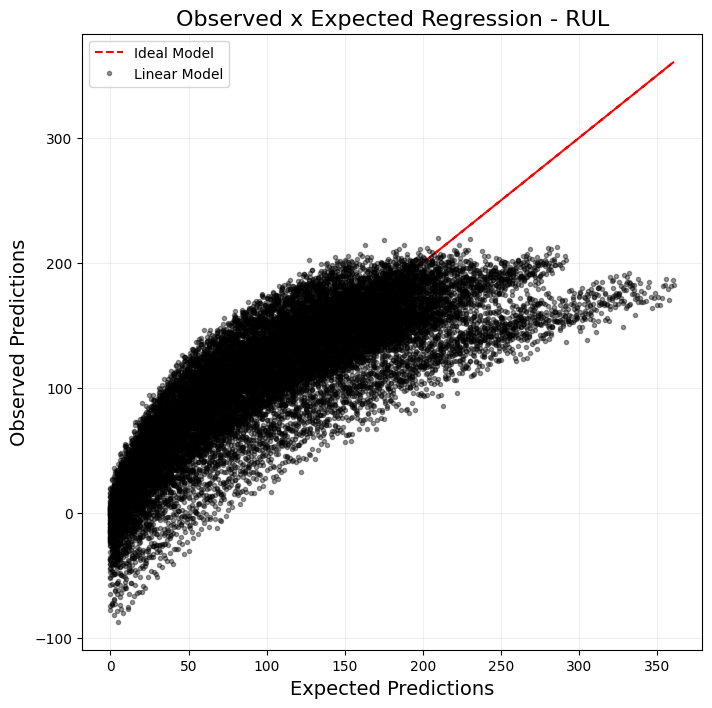

In [11]:
# expected vs observed plot
plt.figure(figsize=(8, 8))
plt.plot(y, y, 'r--', label='Ideal Model')
plt.plot(y, yhat_linear, 'k.', alpha=0.4, label='Linear Model')
plt.legend(loc='best')
plt.xlabel('Expected Predictions', size=14)
plt.ylabel('Observed Predictions', size=14)
plt.title('Observed x Expected Regression - RUL', size=16)
plt.grid(True, alpha=0.2)
plt.show()

## Non Linear Model Approach

In [12]:
# configure model pipeline and parameters search space
nlinear_model_pipeline = Pipeline([
    ('feature_selector_1', SelectKBest(f_regression)),
    ('scaler', RobustScaler()),
    ('feature_selector_2', SelectFromModel(Lasso(random_state=2))),
    ('nlinear_model', GradientBoostingRegressor(random_state=2))
])

model_params = {
    'feature_selector_1__k': range(1, 8),
    'feature_selector_2__estimator__alpha': np.random.uniform(0.001, 20, 200),
    'nlinear_model__n_estimators': np.random.randint(50, 1000, 200),
    'nlinear_model__learning_rate': np.random.uniform(0.01, 0.9, 200),
    'nlinear_model__max_depth': range(1, 17),
}

In [15]:
# create object to search hyperparameters
nlinear_search = RandomizedSearchCV(
    estimator=nlinear_model_pipeline,
    param_distributions=model_params,
    n_iter=5,
    scoring='r2',
    refit=True,
    cv=kfold
)

# ajuste do modelo
nlinear_search.fit(x, y)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=2, shuffle=True),
                   estimator=Pipeline(steps=[('feature_selector_1',
                                              SelectKBest(score_func=<function f_regression at 0x0000024E5063F310>)),
                                             ('scaler', RobustScaler()),
                                             ('feature_selector_2',
                                              SelectFromModel(estimator=Lasso(random_state=2))),
                                             ('nlinear_model',
                                              GradientBoostingRegressor(random_state=2))]),
                   n_iter...
       563, 485, 949, 634, 502, 744, 903, 136, 276, 371, 137, 743, 577,
       304, 667, 140, 583,  53, 499, 204, 882, 977, 850, 109, 965,  82,
       514, 399, 435, 867, 551, 800, 804, 885, 887, 264, 683, 243, 836,
       821, 737, 486, 793, 565, 193, 541, 201, 526, 420, 672, 369, 601,
       432, 545, 417, 865, 445, 680, 151, 315, 209, 873, 400, 533, 320,
        73, 141, 734,  66, 931, 129, 252, 730, 627, 794, 434, 328, 981,
       667, 130, 443, 931, 109, 214, 465, 457, 107, 715, 463, 169, 828,
       900, 762, 791, 988, 327])},
                   scoring='r2')

In [16]:
print('Best Combination of Parameters:')
print(nlinear_search.best_params_)

Best Combination of Parameters:
{'nlinear_model__n_estimators': 73, 'nlinear_model__max_depth': 6, 'nlinear_model__learning_rate': 0.33057390855603735, 'feature_selector_2__estimator__alpha': 4.31430766374423, 'feature_selector_1__k': 7}


In [17]:
print('Best Average Score:')
print(nlinear_search.best_score_)

Best Average Score:
0.6678477604636232


In [18]:
# lets analyse the metrics in the full dataset
nlinear_model = nlinear_search.best_estimator_

# make predictions
yhat_nlinear = nlinear_model.predict(x)

print('Mean Absolute Error: ', mean_absolute_error(y, yhat_nlinear))
print('R2 Score: ', r2_score(y, yhat_nlinear))

Mean Absolute Error:  20.959589865278158
R2 Score:  0.8205973130929152


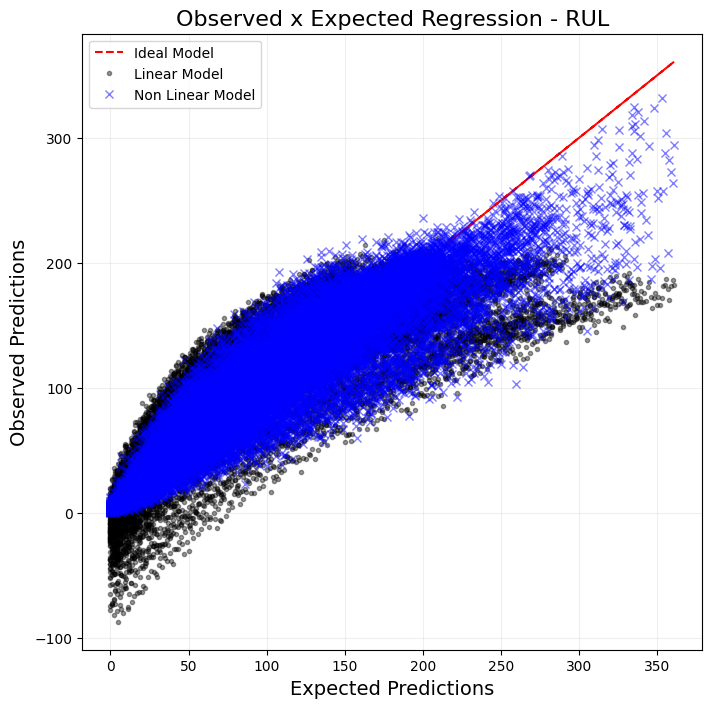

In [19]:
# expected vs observed plot
plt.figure(figsize=(8, 8))
plt.plot(y, y, 'r--', label='Ideal Model')
plt.plot(y, yhat_linear, 'k.', alpha=0.4, label='Linear Model')
plt.plot(y, yhat_nlinear, 'bx', alpha=0.5, label='Non Linear Model')
plt.legend(loc='best')
plt.xlabel('Expected Predictions', size=14)
plt.ylabel('Observed Predictions', size=14)
plt.title('Observed x Expected Regression - RUL', size=16)
plt.grid(True, alpha=0.2)
plt.show()

In [20]:
# analysis of residues
y['pred'] = yhat_nlinear
y['residues'] = y['rul'] - y['pred']

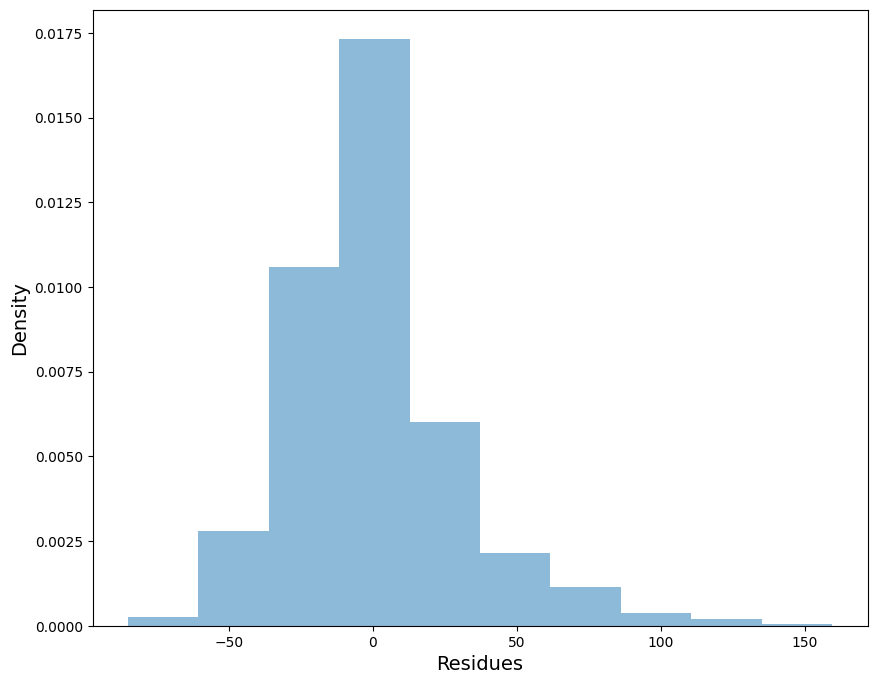

In [21]:
# plot distributions of residues
plt.figure(figsize=(10, 8))
plt.hist(y['residues'], density=True, alpha=0.5)
plt.xlabel('Residues', size=14)
plt.ylabel('Density', size=14)
plt.show()

In [22]:
# save model
if not os.path.isdir(MODELS):
    os.makedirs(MODELS)

joblib.dump(nlinear_model, os.path.join(MODELS, 'regression_model.m'))

['../../models\\regression_model.m']